In [124]:
import tensorflow as tf
import keras as keras
from keras.layers import *
from keras.models import *
from keras.optimizers import *

import pandas as pd
import cv2

from matplotlib import pyplot as plt

import sklearn

In [125]:
train_df = pd.read_csv("../../data/actor_age/train/train.csv")
test_df = pd.read_csv("../../data/actor_age/test/test.csv")

In [126]:
train_df.dtypes

ID       object
Class    object
dtype: object

In [127]:
# train_df = train_df.iloc[:10000]
train_df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [128]:
test_df.head()

,ID
0,25321.jpg
1,989.jpg
2,19277.jpg
3,13093.jpg
4,5367.jpg


In [206]:
img_width = 32
img_height = 32
def get_img(img_id, phase="train"):
    # Load as grayscale
    img_path = '../../data/actor_age/'+ phase +'/images/' + img_id
#     print(img_path)
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    # Reduce size
    resized = cv2.resize(img, (img_width, img_height))
    return resized

print(train_df['ID'][0])
img = get_img(train_df['ID'][0])
img.shape

377.jpg


(32, 32, 3)

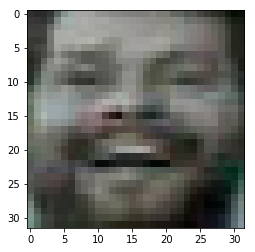

In [207]:
%matplotlib inline
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# cv2.imshow('image',img_arr)
plt.imshow(img)

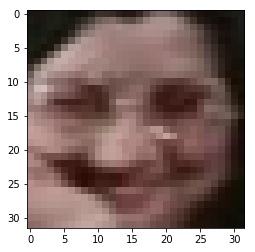

In [208]:
img = get_img(test_df['ID'][0], phase="test")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# cv2.imshow('image',img_arr)
plt.imshow(img)

In [209]:
def generate_input(df, phase):
    X = []
    df['ID'].apply(lambda a: X.append(get_img(a, phase)))
    return X

train_X = np.array(generate_input(train_df, "train"))
test_X = np.array(generate_input(test_df, "test"))
print(train_X.shape)
print(test_X.shape)
# train_X.size

(19906, 32, 32, 3)
(6636, 32, 32, 3)


In [307]:
from sklearn.preprocessing import OneHotEncoder

def generate_output(df):
    dict = { 'YOUNG' : 0, 'MIDDLE': 1, 'OLD': 2 }
    out_Y = []
    df['Class'].apply(lambda a: out_Y.append(dict[a]))
    out_Y = np.array(out_Y)
    # print(train_Y)
    # print(tf.one_hot(train_Y, 3))
    np.array(tf.one_hot(out_Y, 3))
    # print(pd.get_dummies(train_df['Class']))
    one_hot_Encoder = OneHotEncoder(sparse=False)
    out_Y = np.array(one_hot_Encoder.fit_transform(out_Y.reshape((-1, 1))))
    # print(train_Y)
    out_Y.shape
    return out_Y
train_Y = generate_output(train_df)
# test_Y = generate_output(test_df)

In [349]:
nb_filters1 = 64
conv1_size = 3
pool_size = 2

model = Sequential()
model.add(BatchNormalization(input_shape=(img_width,img_height, 3)))
model.add(Conv2D(nb_filters1, (conv1_size, conv1_size), padding="same", input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
# model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=(pool_size)))

In [350]:
nb_filter2 = 48
conv2_size = 3

model.add(Conv2D(nb_filter2, (conv2_size, conv2_size), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

nb_filter3 = 32
conv3_size = 3

model.add(Conv2D(nb_filter3, (conv3_size, conv3_size), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

# model.add(Conv2D(nb_filter3, (conv3_size, conv3_size), padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))
# model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

In [351]:
num_classes = 3

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

In [352]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_79 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
batch_normalization_80 (Batc (None, 32, 32, 64)        256       
_________________________________________________________________
activation_86 (Activation)   (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 16, 16, 48)        27696     
_________________________________________________________________
batch_normalization_81 (Batc (None, 16, 16, 48)        192       
__________

In [353]:
opt = SGD(lr=0.01)
model.compile(optimizer="nadam",
              loss='categorical_crossentropy', metrics=['accuracy'])
train_Y.shape

(19906, 3)

In [354]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [1]:
datagen = keras.preprocessing.image.ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=True,
    rotation_range=4,
    width_shift_range=0.08,
    height_shift_range=0.08,
    horizontal_flip=False,
    validation_split=0.1)

# datagen.fit(train_X)

model.fit_generator(datagen.flow(train_X, train_Y, batch_size=32),
                    steps_per_epoch=len(train_X) / 32, epochs=400)

# model.fit(x=train_X, y=train_Y, epochs=500, validation_split=0.1)

NameError: name 'keras' is not defined

In [356]:
# model.fit(x=train_X, y=train_Y, epochs=5, validation_split=0.1)

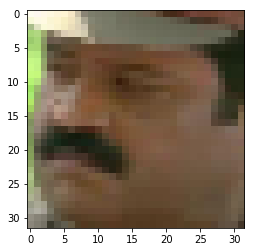

In [357]:
img = cv2.cvtColor(train_X[7000], cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [358]:
prediction = model.predict(train_X[7000:7001])
prediction = prediction.argmax(axis=1)
prediction

array([1])

In [359]:
train_Y[7000:7001].argmax(axis=1)

array([1])

In [360]:
model.evaluate(train_X[:19000], train_Y[:19000])

19000/19000 [==============================] - 5s 239us/step


[0.02885702572684539, 0.9976842105263158]

In [361]:
test_Y = model.predict(test_X)

In [362]:
test_Y = test_Y.argmax(axis=1)

In [363]:
dict1 = { 'YOUNG' : 0, 'MIDDLE': 1, 'OLD': 2 }
test_C = []
for i in range(test_Y.shape[0]):
    test_C.append(list(dict1.keys())[list(dict1.values()).index(test_Y[i])])
# test_C
test_df['Class'] = test_C

In [364]:
test_df.dtypes

ID       object
Class    object
dtype: object

In [366]:
test_df.to_csv("test_out.csv", columns=["ID", "Class"], index=False)